<h2>About this Project</h2>

In this project, you will implement cross validation to pick the best `depth` (hyperparameter) for a regression tree, again using the ION dataset.

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
</ol>
<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

## Get Started

<p>Let's import a few packages that you will need. You will work with the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a> dataset for this project.</p> 

In [1]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time

%matplotlib notebook

from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.6.8


In [2]:
data = loadmat("ion.mat")
xTr  = data['xTr'].T
yTr  = data['yTr'].flatten()
xTe  = data['xTe'].T
yTe  = data['yTe'].flatten()
print(f'Number of features: {xTr.shape[1]}')
print(f'Number of training points: {xTr.shape[0]}')
print(f'Number of testing points: {xTe.shape[0]}')

Number of features: 34
Number of training points: 281
Number of testing points: 70


You are provided a regression-tree-based classifier to use. In addition to what you implemented in the first project, we added a `depth` hyperparameter to the classifier, specified as an argument. This `depth` argument allows us to restrict the maximum depth of the tree model. 

The following code cell shows you how to instantiate a regression tree.

In [3]:
# Create a regression tree with no restriction on its depth. 
# This is equivalent to what you implemented in the previous project

# **If you want to create a tree of max depth k, then call RegressionTree(depth=k)**
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTr, yTr)

# To use the trained regression tree to make prediction
pred = tree.predict(xTr)

We have also created a square loss function that takes in the prediction <code>pred</code> and ground truth <code>truth</code> and returns the average square loss between prediction and ground truth. 

In [4]:
def square_loss(pred, truth):
    """
    Calculates the loss between predicted and true labels.
    
    Input:
        pred: n-dimensional vector of predicted labels
        truth: n-dimensional vector of true labels
        
    Output:
        loss: average squared loss
    """
    return np.mean((pred - truth)**2)

Now, look at the performance of your tree on both the training set and test set using the code cell below.

In [5]:
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

Training Loss: 0.0000
Test Loss: 0.6857


## Implement Cross Validation

As you can see, your tree achives zero training loss on the training set but not zero test loss. Clearly, the tree is overfitting! To reduce overfitting, you need to control the depth of the tree.

One way to pick the optimal depth is to do $k$-Fold Cross Validation. To do so, you will first implement `grid_search`, which finds the best depths given a training set and validation set. Then you will implement `generate_kFold`, which generates a pair of training and validation set for grid search. Finally, you will combine the two functions by implementing `cross_validation`.

### Part One: Implement `grid_search` [Graded]

Implement the function **`grid_search`**, which takes in a training set `xTr, yTr`, a validation set `xVal, yVal` and a list of tree depth candidates `depths`. Your job here is to fit a regression tree for each depth candidate on the training set `xTr, yTr`, evaluate the fitted tree on the validation set `xVal, yVal`, and then pick the candidate that yields the lowest loss for the validation set. 

**Implementation Notes:**
- Use the `square_loss` function to calculate the training and validation loss for corresponding predictions against true labels `yTr` and `yVal` respectively.
- In the event of a tie, return the depth that appears first in `depths` list (`np.argmin` on the list of validation losses will give you the first index in case of a tie).

In [6]:
def grid_search(xTr, yTr, xVal, yVal, depths):
    """
    Calculates the training and validation loss for trees trained on xTr and validated on yTr with a number of depths.
    
    Input:
        xTr: nxd training data matrix
        yTr: n-dimensional vector of training labels
        xVal: mxd validation data matrix
        yVal: m-dimensional vector of validation labels
        depths: a list of len k of depths
        
    Output:
        best_depth, training_losses, validation_losses
        best_depth: the depth that yields that lowest validation loss
        training_losses: a list of len k. the i-th entry corresponds to the the training loss of the tree of depth=depths[i]
        validation_losses: a list of len k. the i-th entry corresponds to the the validation loss of the tree of depth=depths[i]
    """
    training_losses = []
    validation_losses = []
    best_depth = None
    
    for i in range(len(depths)):
        # Create a tree of max depth depths[i]
        tree = RegressionTree(depth=depths[i])
        # Fit/train the regression tree with training data
        tree.fit(xTr, yTr)
        # Use the trained regression tree to make prediction on the training data and validation data
        pred_train = tree.predict(xTr)
        pred_val = tree.predict(xVal)
        #append to val_loss
        training_losses.append(square_loss(pred_train,yTr))
        validation_losses.append(square_loss(pred_val, yVal))
    val_loss = np.array(validation_losses)
    best_depth = depths[np.argmin(val_loss)]
    return best_depth, training_losses, validation_losses    

We can do a dry run with sample depths and plot the training and validation losses against the tree depth. Observe that the training loss continues to decrease with increasing depth, but the validation loss starts to increase after a minimum.

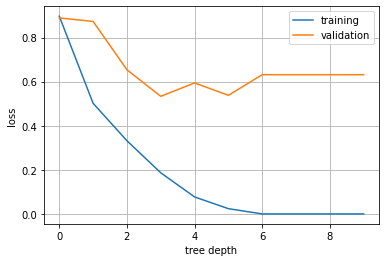

Best depth: 3, validation loss: 0.53


In [7]:
depths = np.arange(10)

# 80-20 split of the training data for demo purposes here
train_split = int(0.8 * xTr.shape[0])
best_depth, training_losses, validation_losses = grid_search(xTr[:train_split], yTr[:train_split], xTr[train_split:], yTr[train_split:], depths)

plt.plot(depths, training_losses, label='training')
plt.plot(depths, validation_losses, label='validation')
plt.xlabel('tree depth')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

print(f'Best depth: {best_depth}, validation loss: {np.min(validation_losses):.2f}')

In [8]:
# The following tests check that your implementation of grid search returns the correct number of training and validation loss values and the correct best depth

depths = [1,2,3,4,5]
k = len(depths)

# 80-20 split of the training data
train_split = int(0.8 * xTr.shape[0])
best_depth, training_losses, validation_losses = grid_search(xTr[:train_split], yTr[:train_split], xTr[train_split:], yTr[train_split:], depths)
best_depth_grader, training_losses_grader, validation_losses_grader = grid_search_grader(xTr[:train_split], yTr[:train_split], xTr[train_split:], yTr[train_split:], depths)

# Check the length of the training loss
def grid_search_test1():
    return (len(training_losses) == k) 

# Check the length of the validation loss
def grid_search_test2():
    return (len(validation_losses) == k)

# Check the argmin
def grid_search_test3():
    return (best_depth == depths[np.argmin(validation_losses)])

def grid_search_test4():
    return (best_depth == best_depth_grader)

def grid_search_test5():
    return np.linalg.norm(np.array(training_losses) - np.array(training_losses_grader)) < 1e-7

def grid_search_test6():
    return np.linalg.norm(np.array(validation_losses) - np.array(validation_losses_grader)) < 1e-7

runtest(grid_search_test1, 'grid_search_test1')
runtest(grid_search_test2, 'grid_search_test2')
runtest(grid_search_test3, 'grid_search_test3')
runtest(grid_search_test4, 'grid_search_test4')
runtest(grid_search_test5, 'grid_search_test5')
runtest(grid_search_test6, 'grid_search_test6')

Running Test: grid_search_test1 ... ✔ Passed!
Running Test: grid_search_test2 ... ✔ Passed!
Running Test: grid_search_test3 ... ✔ Passed!
Running Test: grid_search_test4 ... ✔ Passed!
Running Test: grid_search_test5 ... ✔ Passed!
Running Test: grid_search_test6 ... ✔ Passed!


In [9]:
# Autograder test cell - worth 1 point
# runs grid search test#

In [10]:
# Autograder test cell - worth 1 point
# runs grid search test2

In [11]:
# Autograder test cell - worth 1 point
# runs grid search test3

In [12]:
# Autograder test cell - worth 1 point
# runs grid search test4

In [13]:
# Autograder test cell - worth 1 point
# runs grid search test5

In [14]:
# Autograder test cell - worth 1 point
# runs grid search test6

### Part Two: Implement `generate_kFold`[Graded]

Now, implement the **`generate_kFold`** function, which takes in the number of training examples `n` and the number of folds `k` and returns a list of `k` folds, where each fold takes the form `(training indices, validation indices)`.

For instance, if `n = 3` and `k = 3`, then we have three indices `[0, 1, 2]` and we are trying to split it `k = 3` times to obtain different training/validation splits. One _possible_ output of the the function is `[ ([0, 1], [2]), ([1, 2], [0]), ([0, 2], [1]) ]`. It is possible that `k` might not divide `n` with remainder 0. In that case, you can divide `n` `k-1` times fully and have the remainder constitute the final fold. For instance, if `n = 5` and `k = 4`, one _possible_ output is `[ ([1, 2, 3, 4], [0]), ([0, 2, 3, 4], [1]), ([0, 1, 3, 4], [2]), ([0, 1, 2], [3, 4]) ]`.

Ensure that no two folds have the same indices as it is wasteful to train a model on the same training/validation split again.

One possible algorithm: divide the list of `n` indices into `k` parts and loop `k` times, collecting all but 1 parts into the training set for that fold and leaving that part as the validation set.

In [15]:
def generate_kFold(n, k):
    """
    Generates [(training_indices, validation_indices), ...] for k-fold validation.
    
    Input:
        n: number of training examples
        k: number of folds
    
    Output:
        kfold_indices: a list of length k. Each entry takes the form (training indices, validation indices)
    """
    assert k >= 2
    kfold_indices = []
    
    fold_size = n//k
    r = n % k
    
    indices = list(range(n))
    
    for i in range(k-1):
        val_ind = indices[fold_size*i:fold_size*(i+1)]
        train_ind = indices[fold_size*(i+1):]
        if i > 0:
            train_ind_left = indices[:fold_size*i]
            train_ind = train_ind_left + train_ind
        
        kfold_indices.append((train_ind,val_ind))
    val_ind = indices[fold_size*(k-1):]
    train_ind = indices[:fold_size*(k-1)]
    kfold_indices.append((train_ind,val_ind))
    return kfold_indices

In [16]:
print(f'3-fold splits on 3 points: {generate_kFold(3, 3)}')
print(f'4-fold splits on 5 points: {generate_kFold(5, 4)}')

3-fold splits on 3 points: [([1, 2], [0]), ([0, 2], [1]), ([0, 1], [2])]
4-fold splits on 5 points: [([1, 2, 3, 4], [0]), ([0, 2, 3, 4], [1]), ([0, 1, 3, 4], [2]), ([0, 1, 2], [3, 4])]


In [17]:
# The following tests check that your generate_kFold function 
# returns the correct number of total indices, 
# train and validation indices, and the correct ratio

kfold_indices = generate_kFold(1004, 5)

def generate_kFold_test1():
    return len(kfold_indices) == 5 # you should generate 5 folds

def generate_kFold_test2():
    t = [((len(train_indices) + len(validation_indices)) == 1004) 
         for (train_indices, validation_indices) in kfold_indices]
    return np.all(t) # make sure that for each fold, the number of examples sum up to 1004

def generate_kFold_test3():
    ratio_validation = []
    for (train_indices, validation_indices) in kfold_indices:
        ratio = len(validation_indices) / len(train_indices)
        ratio_validation.append((ratio > 0.24 and ratio < 0.26))
    # make sure that for each fold, the training to validation 
    # examples ratio is in between 0.24 and 0.25
    return np.all(ratio_validation) 

def generate_kFold_test4():
    train_indices_set = set() # to keep track of training indices for each fold
    validation_indices_set = set() # to keep track of validation indices for each fold
    for (train_indices, validation_indices) in kfold_indices:
        train_indices_set = train_indices_set.union(set(train_indices))
        validation_indices_set = validation_indices_set.union(set(validation_indices))
    
    # Make sure that you use all the examples in all the training fold and validation fold
    return train_indices_set == set(np.arange(1004)) and validation_indices_set == set(np.arange(1004))


runtest(generate_kFold_test1, 'generate_kFold_test1')
runtest(generate_kFold_test2, 'generate_kFold_test2')
runtest(generate_kFold_test3, 'generate_kFold_test3')
runtest(generate_kFold_test4, 'generate_kFold_test4')

Running Test: generate_kFold_test1 ... ✔ Passed!
Running Test: generate_kFold_test2 ... ✔ Passed!
Running Test: generate_kFold_test3 ... ✔ Passed!
Running Test: generate_kFold_test4 ... ✔ Passed!


In [18]:
# Autograder test cell - worth 1 point
# runs generate Kfold test1

In [19]:
# Autograder test cell - worth 1 point
# runs generate Kfold test2

In [20]:
# Autograder test cell - worth 1 point
# runs generate Kfold test3

In [21]:
# Autograder test cell - worth 1 point
# runs generate Kfold test4

### Part Three: Implement `cross_validation` [Graded]

Use `grid_search` to implement the **`cross_validation`** function, which takes in the training set `xTr, yTr`, a list of depth candidates `depths` and performs $k$-Fold Cross Validation on the training set.

We will use `generate_kFold` to generate the $k$ training/validation splits and pass in the `indices` for the splits to the `cross_validation` function. Therefore, for each `(training_indices, validation_indices)` element in `indices`, you need to perform grid search to find the training and validation loss for each depth for that fold. Finally, take the average training and validation loss across folds to get the "average" loss. Your implementation should return these 2 loss vectors and the depth with the minimum average validation loss.

In [34]:
def cross_validation(xTr, yTr, depths, indices):
    """
    Performs cross_validation on training data with trees of varying depths. The splits are specified in indices.

    Input:
        xTr: nxd training data matrix
        yTr: n-dimensional vector of training labels
        depths: a list of length l of depths to be tried out
        indices: indices [(training_indices, validation_indices), ...] from generate_kFold,
            specifying the splits for each fold (length k)
    
    Output:
        best_depth: the depth corresponding to the minimum average validation loss.
        training_losses: a list of length l. the i-th entry corresponds to the the average training loss of the tree of depth=depths[i]
        validation_losses: a list of length l. the i-th entry corresponds to the the average validation loss of the tree of depth=depths[i] 
    """

    
    all_train_loss = []
    all_val_loss = []
    
    
    for (train_ind, val_ind) in indices:
        
        best_d, train_losses, val_losses = grid_search(xTr[train_ind], yTr[train_ind], xTr[val_ind], yTr[val_ind], depths)
        """
        best_d: the depth that yields that lowest validation loss
        train_losses: a list of len k. the i-th entry corresponds to the the training loss of the tree of depth=depths[i]
        val_losses: a list of len k. the i-th entry corresponds to the the validation loss of the tree of depth=depths[i]
        """ 
        all_train_loss.append(train_losses)
        all_val_loss.append(val_losses)
    
    t_l = np.array(all_train_loss)
    v_l = np.array(all_val_loss)
    
    training_losses = np.average(t_l, axis=0)
    validation_losses = np.average(v_l, axis=0)
    
    best_depth = depths[np.argmin(validation_losses)]
    #print("Depth with lowest validation loss:",depths[np.argmin(validation_losses)])
    
    return best_depth, training_losses, validation_losses
    
            

In [35]:
depths = [1, 2, 3, 4]
k = len(depths)

# generate indices
# the same indices will be used to cross check your solution and ours
indices = generate_kFold(len(xTr), 5)
best_depth, training_losses, validation_losses = cross_validation(xTr, yTr, depths, indices)
best_depth_grader, training_losses_grader, validation_losses_grader = cross_validation_grader(xTr, yTr, depths, indices)

print("Best depth found by cross_validation:",best_depth)
print("Depth with lowest validation loss:",depths[np.argmin(validation_losses)])

def cross_validation_test4():
    return (best_depth == best_depth_grader)



Best depth found by cross_validation: 2
Depth with lowest validation loss: 2


In [36]:
cross_validation_test4()

True

In [37]:
# The following tests check that your implementation of cross_validation returns the correct number of training and validation losses, the correct "best depth" and the correct values for training and validation loss

depths = [1, 2, 3, 4]
k = len(depths)

# generate indices
# the same indices will be used to cross check your solution and ours
indices = generate_kFold(len(xTr), 5)
best_depth, training_losses, validation_losses = cross_validation(xTr, yTr, depths, indices)
best_depth_grader, training_losses_grader, validation_losses_grader = cross_validation_grader(xTr, yTr, depths, indices)

# Check the length of the training loss
def cross_validation_test1():
    return (len(training_losses) == k) 

# Check the length of the validation loss
def cross_validation_test2():
    return (len(validation_losses) == k)

# Check the argmin
def cross_validation_test3():
    return (best_depth == depths[np.argmin(validation_losses)])

def cross_validation_test4():
    return (best_depth == best_depth_grader)

def cross_validation_test5():
    return np.linalg.norm(np.array(training_losses) - np.array(training_losses_grader)) < 1e-7

def cross_validation_test6():
    return np.linalg.norm(np.array(validation_losses) - np.array(validation_losses_grader)) < 1e-7

runtest(cross_validation_test1, 'cross_validation_test1')
runtest(cross_validation_test2, 'cross_validation_test2')
runtest(cross_validation_test3, 'cross_validation_test3')
runtest(cross_validation_test4, 'cross_validation_test4')
runtest(cross_validation_test5, 'cross_validation_test5')
runtest(cross_validation_test6, 'cross_validation_test6')

Running Test: cross_validation_test1 ... ✔ Passed!
Running Test: cross_validation_test2 ... ✔ Passed!
Running Test: cross_validation_test3 ... ✔ Passed!
Running Test: cross_validation_test4 ... ✔ Passed!
Running Test: cross_validation_test5 ... ✔ Passed!
Running Test: cross_validation_test6 ... ✔ Passed!


In [38]:
# Autograder test cell - worth 1 point
# runs cross validation test1

In [39]:
# Autograder test cell - worth 1 point
# runs cross validation test2

In [40]:
# Autograder test cell - worth 1 point
# runs cross validation test3

In [41]:
# Autograder test cell - worth 1 point
# runs cross validation test4

In [42]:
# Autograder test cell - worth 1 point
# runs cross validation test5

In [43]:
# Autograder test cell - worth 1 point
# runs cross validation test6

<h3>Picking the Right Depth Using Cross Validation</h3>

Run the following cell and you will see that with the tree with the best depth returned from <code>cross_validation</code> would yield higher training loss but lower test loss (less overfitting)!

In [44]:
tree = RegressionTree(depth=np.inf)
print("Learning a tree that can grow to infinite depth")
tree.fit(xTr, yTr)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

print()
print('Cross validate for the best Depth')
depths = [1, 3, 5, 7]
k = len(depths)
indices = generate_kFold(len(xTr), 5)
best_depth, training_losses, validation_losses = cross_validation(xTr, yTr, depths, indices)

tree = RegressionTree(depth=best_depth)
tree.fit(xTr, yTr)
print("Best Depth", best_depth)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

Learning a tree that can grow to infinite depth
Training Loss: 0.0000
Test Loss: 0.6857

Cross validate for the best Depth
Best Depth 3
Training Loss: 0.2216
Test Loss: 0.5812


### Scikit-learn

Scikit-learn has an industry-standard implementation for Cross Validation that is extensively used. The usage is also quite straight-forward.

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

print("Learning a tree that can grow to infinite depth")

tree = DecisionTreeRegressor(
    criterion='mse', # Impurity function = Mean Squared Error (squared loss)
    splitter='best', # Take the best split
    max_depth=None, # Expand the tree to the maximum depth possible
)
tree.fit(xTr, yTr)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

print()
print('Cross validate for the best Depth')
depths = [1, 3, 5, 7]

# Define grid search with a parameter grid and number of folds
tree = GridSearchCV(
    DecisionTreeRegressor(), # model
    param_grid={
        'criterion': ['mse'],
        'splitter': ['best'],
        'max_depth': depths
    }, # grid of parameters
    cv=5, # 5 folds
    n_jobs=-1, # Run on all available cores
)
tree.fit(xTr, yTr)

print("Best Depth", tree.best_params_)

tree = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=tree.best_params_['max_depth'])
tree.fit(xTr, yTr)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

Learning a tree that can grow to infinite depth
Training Loss: 0.0000
Test Loss: 0.7429

Cross validate for the best Depth
Best Depth {'criterion': 'mse', 'max_depth': 3, 'splitter': 'best'}
Training Loss: 0.2216
Test Loss: 0.5812
